# **TP Final: Fine-Tune con DistilBERT**
Integrantes: \
Granitto, Zoe \
Samper, Agustín

# **Setup Inicial y Dependencias**

In [ ]:
!pip install -U transformers
!pip install evaluate
!pip install arxiv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=8ac4de0516ced3a527e988b03ac03975b6fae8e0896ba44be7a02f8563624be5
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from datasets import Dataset
import pandas as pd
import numpy as np
import evaluate
import arxiv
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch.utils.data import DataLoader
assert torch.cuda.is_available(), "GPU not available"

Mounted at /content/drive


# **Datasets**


Funciones utilizadas para la creación del dataset


In [ ]:
"""
Truncates the text at the last space before max_text_length.
"""
def cut(complete_text, max_text_length):
    cut_point = complete_text.rfind(" ", 0, max_text_length) # Last occurrence of "" before the maximum length
    if cut_point == -1:  # None found
        return complete_text[:max_text_length]
    else:
        return complete_text[:cut_point]

"""
Removes newline characters from a string.
"""
def delete_enters(text):
  return text.replace('\n', ' ')

"""
Main function for data collection
"""
def collect(class0, subclass, amount=20, max_text_length=100):
    client = arxiv.Client()
    search = arxiv.Search(
        query=f"cat:{subclass}",
        max_results=amount,
        sort_by=arxiv.SortCriterion.SubmittedDate
    )
    lines = []
    try:
        for result in client.results(search):
            complete_text = result.title.strip() + " " + result.summary.strip()

            if len(complete_text) > max_text_length:
                text = cut(complete_text, max_text_length)
            else:
                text = complete_text
            lines.append((delete_enters(text), class0))
    except arxiv.UnexpectedEmptyPageError:
        print(f"No se pudieron obtener más datos para la subclase: {subclass}. Continuando con la siguiente.")
        pass # Move on to the next subclass if the page's empty

    return lines

Dataset 1: Conjunto de datos, no balanceado, que contiene 3 clases, AI, FL y DS.

In [ ]:
# Mapping dictionary from original classes to new categories
mapping = {
    "AI" : [
        "cs.LG", # Machine Learning
        "cs.MA", # Multiagent Systems
        "cs.AI"  # Artificial Intelligence
        ],

    "FL" : [
        "cs.CL", # Computation and Language (NLP)
        "cs.FL", # Formal Languages
        "cs.LO"  # Logic in Computer Science
        ],

    "DS" : [
        "cs.DM", # Discrete Mathematics
        "cs.DS", # Data Structures and Algorithms
        "cs.CC"  # Computational Complexity
        ]
    }

# Build the dataset
data = []
for class0 in mapping:
  for subclass in mapping[class0]:
    data.extend(collect(class0, subclass, amount=180, max_text_length=300))

df = pd.DataFrame(data, columns=["text", "labels"])
df.to_csv("dataset_similares.csv", index=False)

Dataset 2: Conjunto de datos, no balanceado, que contiene 3 clases, Mathematics, Physics y Computer Science.

In [ ]:
# Mapping dictionary from original classes to new categories
mapping = {
    "Computer Science": [
      "cs.AI",  # Artificial Intelligence
      "cs.AR",  # Hardware Architecture
      "cs.CC",  # Computational Complexity
      "cs.CE",  # Computational Engineering, Finance, and Science
      "cs.CG",  # Computational Geometry
      "cs.CL",  # Computation and Language (NLP)
      "cs.CR",  # Cryptography and Security
      "cs.CV",  # Computer Vision and Pattern Recognition
      "cs.CY",  # Computers and Society
      "cs.DB",  # Databases
      "cs.DC",  # Distributed, Parallel, and Cluster Computing
      "cs.DL",  # Digital Libraries
      "cs.DM",  # Discrete Mathematics
      "cs.DS",  # Data Structures and Algorithms
      "cs.ET",  # Emerging Technologies
      "cs.FL",  # Formal Languages
      "cs.GL",  # General Literature
      "cs.GR",  # Graphics
      "cs.GT",  # Computer Science and Game Theory
      "cs.HC",  # Human-Computer Interaction
      "cs.IR",  # Information Retrieval
      "cs.IT",  # Information Theory
      "cs.LG",  # Machine Learning
      "cs.LO",  # Logic in Computer Science
      "cs.MA",  # Multiagent Systems
      "cs.MM",  # Multimedia
      "cs.MS",  # Mathematical Software
      "cs.NA",  # Numerical Analysis
      "cs.NE",  # Neural and Evolutionary Computing
      "cs.NI",  # Networking and Internet Architecture
      "cs.OH",  # Other
      "cs.OS",  # Operating Systems
      "cs.PF",  # Performance
      "cs.PL",  # Programming Languages
      "cs.RO",  # Robotics
      "cs.SC",  # Symbolic Computation
      "cs.SD",  # Sound
      "cs.SE",  # Software Engineering
      "cs.SI",  # Social and Information Networks
      "cs.SY",  # Systems and Control
    ],

    "Physics": [
      "physics.acc-ph",  # Accelerator Physics
      "physics.app-ph",  # Applied Physics
      "physics.ao-ph",   # Atmospheric and Oceanic Physics
      "physics.atom-ph", # Atomic Physics
      "physics.atm-clus",# Atomic and Molecular Clusters
      "physics.bio-ph",  # Biological Physics
      "physics.chem-ph", # Chemical Physics
      "physics.class-ph",# Classical Physics
      "physics.comp-ph", # Computational Physics
      "physics.data-an", # Data Analysis, Statistics and Probability
      "physics.ed-ph",   # Physics Education
      "physics.flu-dyn", # Fluid Dynamics
      "physics.gen-ph",  # General Physics
      "physics.geo-ph",  # Geophysics
      "physics.hist-ph", # History and Philosophy of Physics
      "physics.ins-det", # Instrumentation and Detectors
      "physics.med-ph",  # Medical Physics
      "physics.optics",  # Optics
      "physics.plasm-ph",# Plasma Physics
      "physics.pop-ph",  # Popular Physics
      "physics.soc-ph",  # Physics and Society
      "physics.space-ph" # Space Physics
    ],

    "Mathematics": [
      "math.AG",  # Algebraic Geometry
      "math.AT",  # Algebraic Topology
      "math.AP",  # Analysis of PDEs
      "math.CT",  # Category Theory
      "math.CA",  # Classical Analysis and ODEs
      "math.CO",  # Combinatorics
      "math.AC",  # Commutative Algebra
      "math.CV",  # Complex Variables
      "math.DG",  # Differential Geometry
      "math.DS",  # Dynamical Systems
      "math.FA",  # Functional Analysis
      "math.GM",  # General Mathematics
      "math.GN",  # General Topology
      "math.GT",  # Geometric Topology
      "math.GR",  # Group Theory
      "math.HO",  # History and Overview
      "math.IT",  # Information Theory
      "math.KT",  # K-Theory and Homology
      "math.LO",  # Logic
      "math.MP",  # Mathematical Physics
      "math.MG",  # Metric Geometry
      "math.NT",  # Number Theory
      "math.NA",  # Numerical Analysis
      "math.OA",  # Operator Algebras
      "math.OC",  # Optimization and Control
      "math.PR",  # Probability
      "math.QA",  # Quantum Algebra
      "math.RT",  # Representation Theory
      "math.RA",  # Rings and Algebras
      "math.SP",  # Spectral Theory
      "math.ST",  # Statistics Theory
      "math.SG"   # Symplectic Geometry
    ]

}

# Build the dataset
data = []
for class0 in mapping:
  for subclass in mapping[class0]:
    data.extend(collect(class0, subclass, amount=16, max_text_length=300))

df = pd.DataFrame(data, columns=["text", "labels"])
df.to_csv("dataset_distintos.csv", index=False)

# **Funciones auxiliares**

Métricas

In [ ]:
"""
Tokenizes the input text using the defined tokenizer.
"""
def tokenize_function(input):
    return tokenizer(input["text"], padding='max_length', truncation=True)

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1) # For classification: choose the class (id) with highest probability

    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Measures the proportion of total predictions that were correct
    acc = accuracy_metric.compute(predictions=predictions, references=labels)

    # Precision = TP / (TP + FP)
    # Of al positive prediction, how many were actually correct
    prec = precision_metric.compute(predictions=predictions, references=labels, average='macro')

    # Recall = TP / (TP + FN)
    # Of all actual positive samples, how many were correctly identified
    rec = recall_metric.compute(predictions=predictions, references=labels, average='macro')

    # look for a balance between precision and recall.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"]
    }

class Metrics:
    def __init__(self, id2cath):
        self.id2cath = id2cath

    def __call__(self, eval_pred):
        logits, labels = eval_pred
        predictions = logits.argmax(axis=-1)  # For classification: choose the class (id) with highest probability

        # Accuracy = (TP + TN) / (TP + TN + FP + FN)
        # Measures the proportion of total predictions that were correct
        acc = accuracy_metric.compute(predictions=predictions, references=labels)

        # Macro-averaged metrics
        # Precision = TP / (TP + FP)
        # Of all positive predictions, how many were actually correct
        prec_macro = precision_metric.compute(predictions=predictions, references=labels, average='macro')

        # Recall = TP / (TP + FN)
        # Of all actual positive samples, how many were correctly identified
        rec_macro = recall_metric.compute(predictions=predictions, references=labels, average='macro')

        # F1 = 2 * (precision * recall) / (precision + recall)
        f1_macro = f1_metric.compute(predictions=predictions, references=labels, average='macro')

        # Per-class metrics
        prec_per_class = precision_metric.compute(predictions=predictions, references=labels, average=None)
        rec_per_class = recall_metric.compute(predictions=predictions, references=labels, average=None)
        f1_per_class = f1_metric.compute(predictions=predictions, references=labels, average=None)

        # Map per-class metrics to class labels
        per_class_metrics = {}
        for i in self.id2cath.keys():
            class_label = self.id2cath[i]
            per_class_metrics[class_label] = {
                "precision": prec_per_class["precision"][i],
                "recall": rec_per_class["recall"][i],
                "f1": f1_per_class["f1"][i]
            }

        return {
            "accuracy": acc["accuracy"],
            "precision_macro": prec_macro["precision"],
            "recall_macro": rec_macro["recall"],
            "f1_macro": f1_macro["f1"],
            "per_class_metrics": per_class_metrics
        }

"""
Function to predict the class of a given text.
"""
def class_prediction(model, text):

    # Converts the input text into tokens
    inputs = tokenizer(text,
                       padding='max_length',
                       truncation=True,
                       max_length=tokenizer.model_max_length,
                       return_tensors='pt')

    # Move input tensors to the device
    inputs = {name: tensor.to(model.device) for name, tensor in inputs.items()}

    # Infer an output
    outputs = model(**inputs)

    # Obtain the logits (which activation function will use)
    logits = outputs.logits

    # Obtain the probabilidades
    probabilities = torch.softmax(logits, dim=-1)

    # Obtain the most probable class for the given text
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    predicted_category = id2cath[predicted_class_id]

    # Returns the predicted class and the probabilities for all classes
    return predicted_category, probabilities[0].tolist()

"""
Used to compute metrics from the predictions of the trained model in a test set
The input dataset must be tokenized
"""
def dataset_prediction(model, dataset):
    model.eval()
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    all_preds, all_labels = [], []
    test_loader = DataLoader(dataset, batch_size = 16)

    with torch.no_grad():
        for batch in test_loader:
            # Move inputs and labels to device
            inputs = {k: v.to(model.device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            labels = batch["labels"].to(model.device)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)
    precision = precision_metric.compute(predictions=all_preds, references=all_labels, average="weighted")
    recall = recall_metric.compute(predictions=all_preds, references=all_labels, average="weighted")
    f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average="weighted")

    # Per-class metrics
    prec_per_class = precision_metric.compute(predictions=all_preds, references=all_labels, average=None)
    rec_per_class = recall_metric.compute(predictions=all_preds, references=all_labels, average=None)
    f1_per_class = f1_metric.compute(predictions=all_preds, references=all_labels, average=None)

    # Map per-class metrics to class labels
    per_class_metrics = {}
    for i in id2cath.keys():
        class_label = id2cath[i]
        per_class_metrics[class_label] = {
            "precision": prec_per_class["precision"][i],
            "recall": rec_per_class["recall"][i],
            "f1": f1_per_class["f1"][i]
        }

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
        "per_class_metrics": per_class_metrics
    }

"""
Function to format metrics data from trainer.state.log_history into structured lists per epoch
"""
def getMetricsDataGeneral(logs):
    metrics_per_epoch = {}

    for log in logs:
        if 'epoch' in log:
            epoch = int(log['epoch'])  # Use integer epoch as key
            if epoch not in metrics_per_epoch:
                metrics_per_epoch[epoch] = {}

            if 'loss' in log:  # training loss
                metrics_per_epoch[epoch]['train_loss'] = log['loss']
            elif 'eval_loss' in log:  # eval metrics
                metrics_per_epoch[epoch]['eval_loss'] = log['eval_loss']
                metrics_per_epoch[epoch]['accuracy'] = log.get('eval_accuracy')
                metrics_per_epoch[epoch]['precision'] = log.get('eval_precision_macro')
                metrics_per_epoch[epoch]['recall'] = log.get('eval_recall_macro')
                metrics_per_epoch[epoch]['f1'] = log.get('eval_f1_macro')

                if 'eval_per_class_metrics' in log:
                    metrics_per_epoch[epoch]['per_class_metrics'] = log['eval_per_class_metrics']

    # Sort epochs and extract metrics
    sorted_epochs = sorted(metrics_per_epoch.keys())

    epochs = sorted_epochs
    train_loss = [metrics_per_epoch[epoch].get('train_loss') for epoch in sorted_epochs if 'train_loss' in metrics_per_epoch[epoch]]
    eval_loss = [metrics_per_epoch[epoch].get('eval_loss') for epoch in sorted_epochs if 'eval_loss' in metrics_per_epoch[epoch]]
    accuracy = [metrics_per_epoch[epoch].get('accuracy') for epoch in sorted_epochs if 'accuracy' in metrics_per_epoch[epoch]]
    precision = [metrics_per_epoch[epoch].get('precision') for epoch in sorted_epochs if 'precision' in metrics_per_epoch[epoch]]
    recall = [metrics_per_epoch[epoch].get('recall') for epoch in sorted_epochs if 'recall' in metrics_per_epoch[epoch]]
    f1 = [metrics_per_epoch[epoch].get('f1') for epoch in sorted_epochs if 'f1' in metrics_per_epoch[epoch]]
    per_class_metrics = [metrics_per_epoch[epoch].get('per_class_metrics') for epoch in sorted_epochs if 'per_class_metrics' in metrics_per_epoch[epoch]]

    # Ensure lists have the same length by aligning with the shortest list
    min_len = min(len(epochs), len(train_loss), len(eval_loss), len(accuracy),
                    len(precision), len(recall), len(f1), len(per_class_metrics))

    epochs = epochs[:min_len]
    train_loss = train_loss[:min_len]
    eval_loss = eval_loss[:min_len]
    accuracy = accuracy[:min_len]
    precision = precision[:min_len]
    recall = recall[:min_len]
    f1 = f1[:min_len]
    per_class_metrics = per_class_metrics[:min_len]

    return {
        "epochs": epochs,
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "per_class_metrics": per_class_metrics
    }

"""
Function to format metrics data from trainer.state.log_history into structured lists per epoch
The difference with the function before is that the new one only calculate losses and accuracy
"""
def getMetricsDataSimilar(logs):
    metrics_per_epoch = {}

    for log in logs:
        if 'epoch' in log:
            epoch = int(log['epoch'])  # Use integer epoch as key
            if epoch not in metrics_per_epoch:
                metrics_per_epoch[epoch] = {}

            if 'loss' in log:  # training loss
                metrics_per_epoch[epoch]['train_loss'] = log['loss']
            elif 'eval_loss' in log:  # eval metrics
                metrics_per_epoch[epoch]['eval_loss'] = log['eval_loss']
                metrics_per_epoch[epoch]['accuracy'] = log.get('eval_accuracy')

    # Sort epochs and extract metrics
    sorted_epochs = sorted(metrics_per_epoch.keys())

    epochs = sorted_epochs
    train_loss = [metrics_per_epoch[epoch].get('train_loss') for epoch in sorted_epochs if 'train_loss' in metrics_per_epoch[epoch]]
    eval_loss = [metrics_per_epoch[epoch].get('eval_loss') for epoch in sorted_epochs if 'eval_loss' in metrics_per_epoch[epoch]]
    accuracy = [metrics_per_epoch[epoch].get('accuracy') for epoch in sorted_epochs if 'accuracy' in metrics_per_epoch[epoch]]

    # Ensure lists have the same length by aligning with the shortest list
    min_len = min(len(epochs), len(train_loss), len(eval_loss), len(accuracy))

    epochs = epochs[:min_len]
    train_loss = train_loss[:min_len]
    eval_loss = eval_loss[:min_len]
    accuracy = accuracy[:min_len]

    return {
        "epochs": epochs,
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "accuracy": accuracy,
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Entrenamientos

In [ ]:
"""
Splits the given dataset into training, evaluation, and test sets, then generates
multiple versions of the training set with different sizes based on the percentages
provided in the `percentages` list.
The dataset is split into 70% training, 15% evaluation, and 15% test.
Then, from that initial training portion, a list of training subsets is generated
using the percentages given in the `percentages` list. Each subset is randomly
sampled from the initial training set.

The evaluation and test sets remain the same for all generated training subsets.

Parameters:
dataset : pd.DataFrame The dataset, including texts and their labels.
percentages : List(float) A list of percentages (between 0 and 1) indicating the
          sizes of the training subsets to extract from the initial training set.

Returns:
A tuple is returned. The first element is a dictionary where each key is a percentage
and the value is the corresponding training subset. The second element is the test set,
and the third element is the evaluation set.
"""
def create_training_splits(dataset, percentages):
  df_train, df_temp = train_test_split(dataset, test_size=0.3, stratify=dataset['labels'], random_state=42)

  df_test, df_eval = train_test_split(df_temp, test_size=0.5, stratify=df_temp['labels'], random_state=42)

  all_splits = {}

  test_dataset  = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)
  eval_dataset  = Dataset.from_pandas(df_eval).map(tokenize_function, batched=True)
  print("Test size:", len(test_dataset))
  print("Eval size:", len(eval_dataset))
  print(test_dataset)
  print(eval_dataset)

  for per in percentages:
    print(per)
    print(1-per)
    if per != 1.0: # Dont use all dataframe
      df_subtrain, _ = train_test_split(df_train, test_size=1-per,
                                        stratify=df_train['labels'], random_state=42)
    else:
      df_subtrain = df_train

    train_dataset = Dataset.from_pandas(df_subtrain).map(tokenize_function, batched=True)

    # Print the size of each subset
    print("Train size:", len(train_dataset))
    print(train_dataset)

    all_splits[per] = train_dataset

  return all_splits, test_dataset, eval_dataset

"""
    Trains models using different fractions of the training set,
    and automatically selects the one that achieves the lowest `eval_loss`
    on the evaluation set.

    Parameters:
    ----------
    all_splits : dict[float, Dataset]
        Dictionary that maps a percentage (e.g., 0.1, 0.5, 1.0) to a subset
        of the training dataset.

    test_dataset : Dataset
        Final test dataset (not used during training).

    eval_dataset : Dataset
        Evaluation dataset used to select the best-performing model.

    tokenizer : PreTrainedTokenizer
        Tokenizer associated with the model.

    compute_metrics : Callable
        Function that computes custom evaluation metrics (e.g., accuracy, f1, etc.).

    model_path : str
        Path or name of the pretrained model (e.g., "distilbert-base-uncased").

    id2cath : dict
        Dictionary mapping class IDs to labels.

    cath2id : dict
        Dictionary mapping labels to class IDs.

    output_dir : str, optional
        Folder where the training results are saved.

    logging_dir : str, optional
        Folder where the training logs are stored.

    batch_size : int, optional
        Batch size per device (GPU/CPU).

    num_epochs : int, optional
        Number of training epochs.

    learning_rate : float, optional
        Initial learning rate.

    weight_decay : float, optional
        L2 regularization parameter (helps prevent overfitting).

    Returns:
    -------
    model : PreTrainedModel
        The trained model that achieved the lowest `eval_loss` during evaluation.

"""
def train_and_select_best_model(
    all_splits,
    test_dataset,
    eval_dataset,
    tokenizer,
    compute_metrics,
    model_path,
    id2cath,
    cath2id,
    output_dir="./results",
    logging_dir="./logs",
    batch_size=16,
    num_epochs=16,
    learning_rate=5e-5,
    weight_decay=0.05):

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        logging_dir=logging_dir,
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=True
    )

    best_model_info = {}

    for per, datasets in all_splits.items():
        print(f"\nEntrenando el modelo con el {per*100:.0f}% del dataset")

        # Load pre-trained model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_path, num_labels=3, id2label=id2cath, label2id=cath2id
        )

        # freeze all parameters except the classification layer
        for name, param in model.base_model.named_parameters():
            param.requires_grad = False

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=datasets,
            eval_dataset=eval_dataset,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
        )

        train_result = trainer.train()
        epoch_logs = [log for log in trainer.state.log_history if "epoch" in log]

        less_evalloss = None
        for i in epoch_logs:
            if "eval_loss" in i.keys():
                if not less_evalloss or i["eval_loss"] < less_evalloss:
                    less_evalloss = i["eval_loss"]

        if not best_model_info or less_evalloss < best_model_info["eval_loss"]:
            best_model_info["model"] = model
            best_model_info["eval_loss"] = less_evalloss
            best_model_info["per"] = per

        classNames = [id2cath[key] for key in id2cath.keys()]

        # Visualize
        metrics_data = getMetricsDataGeneral(epoch_logs)
        plot_metrics_summary(metrics_data, allMetrics=True)
        plot_metrics_per_class(metrics_data, classNames)

    print(f"\nEl modelo con menor eval_loss fue el entrenado con un {best_model_info['per']*100:.0f}% del dataset")

    return best_model_info["model"]

Gráficos

In [ ]:
"""
Plots two graphics. One with losses and another one next to it with accuracy, preccision, recall and F1
"""
def plot_metrics_summary(metricsData, allMetrics):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Losses
    axs[0].plot(metricsData["epochs"], metricsData["train_loss"], label='Training Loss', marker='o')
    axs[0].plot(metricsData["epochs"], metricsData["eval_loss"], label='Validation Loss', marker='o')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training vs Validation Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Subplot 2: Evaluation metrics
    axs[1].plot(metricsData["epochs"], metricsData["accuracy"], label='Accuracy', marker='x')
    if allMetrics:
      axs[1].plot(metricsData["epochs"], metricsData["precision"], label='Precision', marker='x')
      axs[1].plot(metricsData["epochs"], metricsData["recall"], label='Recall', marker='x')
      axs[1].plot(metricsData["epochs"], metricsData["f1"], label='F1 Score', marker='x')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Metric Value')
    axs[1].set_title('Evaluation Metrics')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

"""
Plots precision, recall, and F1-score per class across training epochs.
Parameters:
- metrics: a dictionary containing a list under the key 'per_class_metrics'.
           Each list element corresponds to one epoch and is a dict with class-wise metrics.
- class_names: list of class names to include in the plot.
"""
def plot_metrics_per_class(metrics, class_names):

    per_class_metrics = metrics["per_class_metrics"]  # List of dicts, one per epoch

    # Initialize a structure to store metric values per class across epochs
    metric_history = {
        class_name: {"precision": [], "recall": [], "f1": []}
        for class_name in class_names
    }

    # Iterate over each epoch and collect metrics per class
    for epoch_data in per_class_metrics:
        for class_name in class_names:
            class_metrics = epoch_data[class_name]
            metric_history[class_name]["precision"].append(class_metrics["precision"])
            metric_history[class_name]["recall"].append(class_metrics["recall"])
            metric_history[class_name]["f1"].append(class_metrics["f1"])

    # Create one figure with 3 subplots (side by side)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

    # Plot Precision per class
    for class_name in class_names:
        axs[0].plot(metrics["epochs"], metric_history[class_name]["precision"], label=class_name)
    axs[0].set_title("Precision per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Score")
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # Plot Recall per class
    for class_name in class_names:
        axs[1].plot(metrics["epochs"], metric_history[class_name]["recall"], label=class_name)
    axs[1].set_title("Recall per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].grid(True)

    # Plot F1-score per class
    for class_name in class_names:
        axs[2].plot(metrics["epochs"], metric_history[class_name]["f1"], label=class_name)
    axs[2].set_title("F1-score per Epoch")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylim(0, 1)
    axs[2].legend()
    axs[2].grid(True)

    # Improve layout to prevent overlap
    plt.tight_layout()
    plt.show()

# **Primer instancia del modelo**

In [ ]:
model_path = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path) # converts text to a tokens sequence and then into numbers
print("Tokenizer input max length:", tokenizer.model_max_length) # check how the tokenizer works
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

cathegories = {"AI" : "Artificial Intelligence",
               "DS" : "Data Structures and Algorithms",
               "FL" : "Formal Languages and Automata Theory"
               }

id2cath = {0:"AI",1:"DS",2:"FL"}
cath2id = {"AI":0,"DS":1,"FL":2}

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


Cargamos el dataset

In [ ]:
# load the dataset
df = pd.read_csv("/content/dataset_parecidos.csv")
df['labels'] = df['labels'].apply(lambda x: cath2id[x]) # replace cathegory names with numbers

# Split the dataset into 70% training, 15% evaluation, and 15% testing with the same
# amount of samples per class
train_data, remaining_data = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=0.5, stratify=remaining_data['labels'], random_state=42)

train_dataset = Dataset.from_pandas(train_data).map(tokenize_function, batched=True)
eval_dataset = Dataset.from_pandas(val_data).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_data).map(tokenize_function, batched=True)

# Print the size of each subset
print("Train size:", len(train_dataset))
print("Eval size:", len(eval_dataset))
print("Test size:", len(eval_dataset))
print(train_dataset)
print(eval_dataset)
print(test_dataset)

test_dataset.save_to_disk('/content/drive/MyDrive/parecidos_test_dataset')

Map:   0%|          | 0/1134 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Train size: 1134
Eval size: 243
Test size: 243
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1134
})
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 243
})
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 243
})


Saving the dataset (0/1 shards):   0%|          | 0/243 [00:00<?, ? examples/s]

Para el problema de clases similares, vamos a aprovechar a crear diferentes instancias del modelo variando el learning rate. Los entrenamos y observamos los resultados

Entrenando el modelo con la configuracion: {'learning_rate': 0.05, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 15}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,23.280400,1.179741,0.481481,0.643751,0.481481,0.446468
2,1.277000,0.938093,0.374486,0.449213,0.374486,0.245235
3,1.400000,0.900746,0.534979,0.612925,0.534979,0.519529
4,1.083500,0.869162,0.596708,0.687949,0.596708,0.604909
5,1.220100,0.867427,0.543210,0.408961,0.543210,0.450537
6,0.946400,0.780768,0.662551,0.721340,0.662551,0.668290
7,0.899300,0.784352,0.658436,0.738052,0.658436,0.662807
8,0.814200,0.734859,0.707819,0.725398,0.707819,0.710017
9,0.796300,0.767606,0.703704,0.716911,0.703704,0.701296
10,0.799000,0.822608,0.703704,0.717361,0.703704,0.698086


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


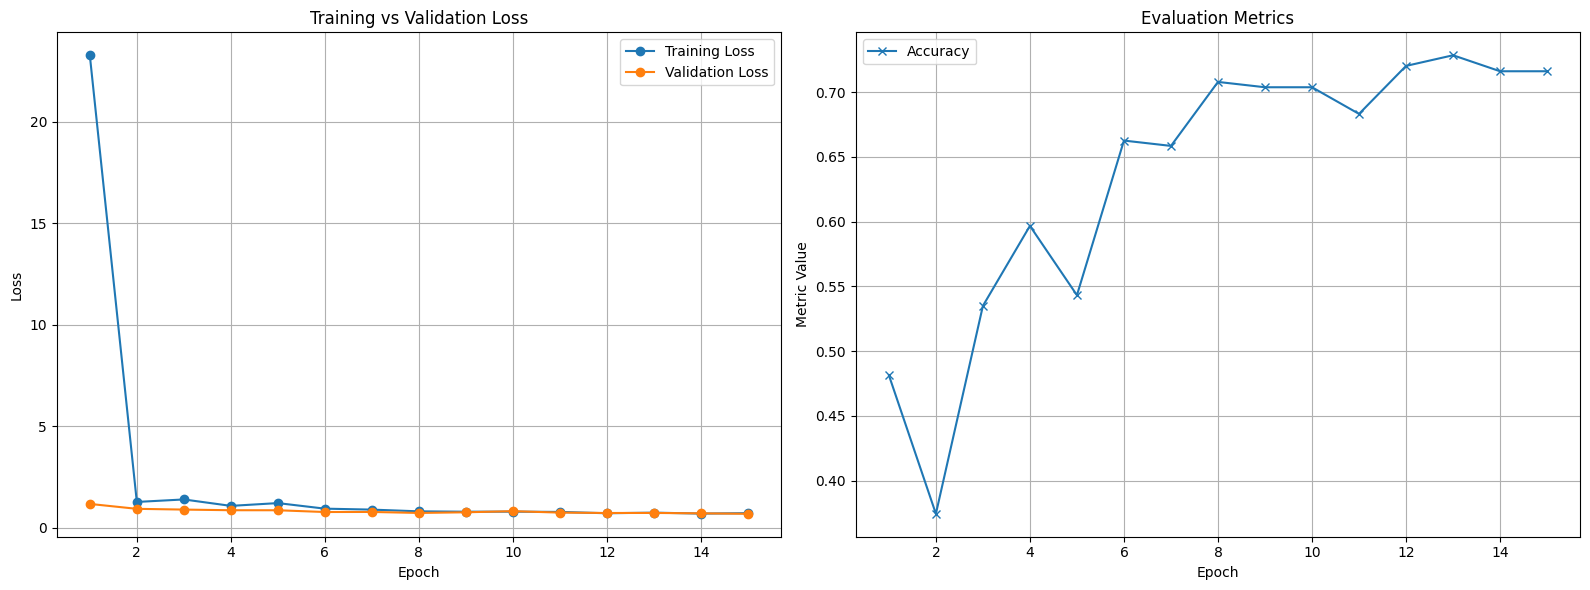

Test dataset: {'eval_loss': 0.656591534614563, 'eval_accuracy': 0.7530864197530864, 'eval_precision': 0.757737751723719, 'eval_recall': 0.7530864197530863, 'eval_f1': 0.7542316107677127, 'eval_runtime': 1.152, 'eval_samples_per_second': 210.946, 'eval_steps_per_second': 26.911, 'epoch': 15.0}
Entrenando el modelo con la configuracion: {'learning_rate': 0.0005, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 15}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.791500,0.704807,0.654321,0.691751,0.654321,0.613501
2,0.660800,0.632700,0.711934,0.739548,0.711934,0.700043
3,0.627900,0.670468,0.691358,0.733719,0.691358,0.663388
4,0.608800,0.582754,0.736626,0.738992,0.736626,0.737246
5,0.590500,0.575079,0.748971,0.748855,0.748971,0.748553
6,0.562800,0.638483,0.711934,0.741548,0.711934,0.702098
7,0.556000,0.617946,0.695473,0.706740,0.695473,0.685833
8,0.545900,0.588513,0.761317,0.764182,0.761317,0.760319
9,0.534900,0.579755,0.748971,0.749588,0.748971,0.747748
10,0.532100,0.578787,0.748971,0.750092,0.748971,0.747837


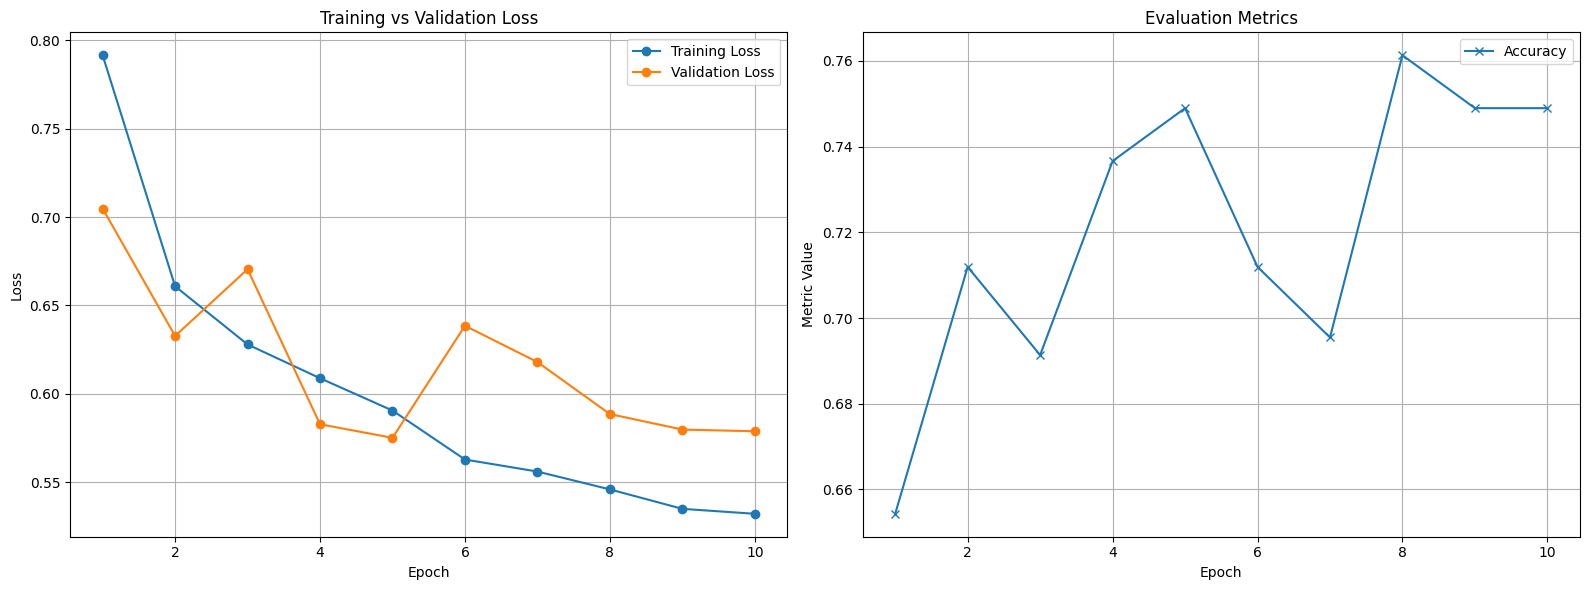

Test dataset: {'eval_loss': 0.6065220236778259, 'eval_accuracy': 0.7407407407407407, 'eval_precision': 0.7377520913403575, 'eval_recall': 0.7407407407407408, 'eval_f1': 0.7368740152517804, 'eval_runtime': 1.121, 'eval_samples_per_second': 216.765, 'eval_steps_per_second': 27.653, 'epoch': 10.0}
Entrenando el modelo con la configuracion: {'learning_rate': 5e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 30}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.090500,1.074805,0.456790,0.402011,0.456790,0.360150
2,1.064100,1.046762,0.572016,0.390152,0.572016,0.460000
3,1.039600,1.023375,0.604938,0.730710,0.604938,0.522554
4,1.019500,1.001149,0.604938,0.730683,0.604938,0.517421
5,1.000300,0.981132,0.646091,0.692955,0.646091,0.600607
6,0.980600,0.962332,0.654321,0.693974,0.654321,0.616534
7,0.965200,0.945246,0.658436,0.698159,0.658436,0.622729
8,0.952700,0.930111,0.658436,0.698159,0.658436,0.622729
9,0.940600,0.916384,0.662551,0.701429,0.662551,0.626261
10,0.924400,0.904260,0.670782,0.717069,0.670782,0.635958


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


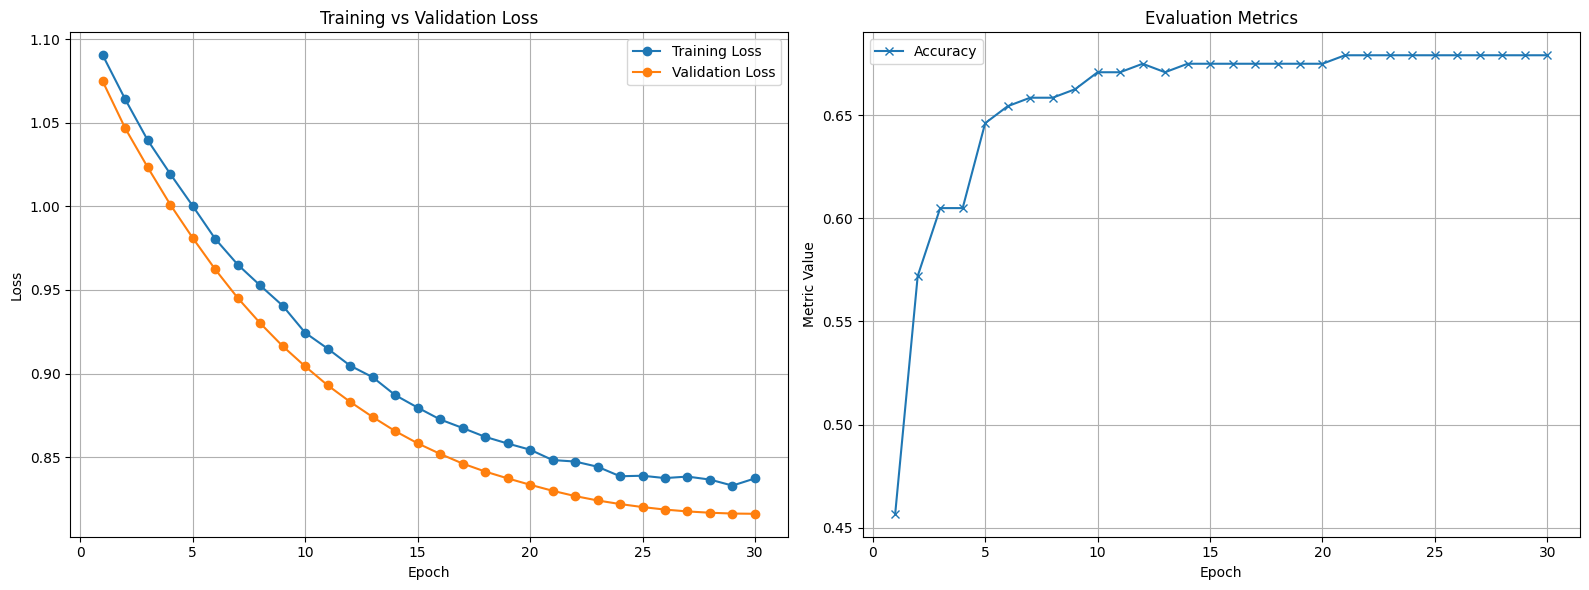

Test dataset: {'eval_loss': 0.8448390960693359, 'eval_accuracy': 0.6419753086419753, 'eval_precision': 0.6296622097114707, 'eval_recall': 0.6419753086419754, 'eval_f1': 0.5958792759859034, 'eval_runtime': 1.1408, 'eval_samples_per_second': 213.009, 'eval_steps_per_second': 27.174, 'epoch': 30.0}
Entrenando el modelo con la configuracion: {'learning_rate': 0.05, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 15, 'lr_scheduler_type': 'constant', 'warmup_steps': 0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,21.742200,3.102285,0.502058,0.711993,0.502058,0.457660
2,1.381200,0.900308,0.563786,0.607609,0.563786,0.563845
3,1.096000,0.959573,0.572016,0.381675,0.572016,0.457805
4,1.058100,0.988825,0.448560,0.365260,0.448560,0.368668
5,1.067400,0.925889,0.580247,0.552990,0.580247,0.507965
6,1.083500,0.889754,0.600823,0.594910,0.600823,0.546542
7,0.950500,0.897461,0.559671,0.547773,0.559671,0.517973
8,0.968100,1.064879,0.572016,0.554343,0.572016,0.479383
9,1.000400,0.942365,0.604938,0.574499,0.604938,0.560348
10,1.006500,0.923123,0.526749,0.549223,0.526749,0.476097


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


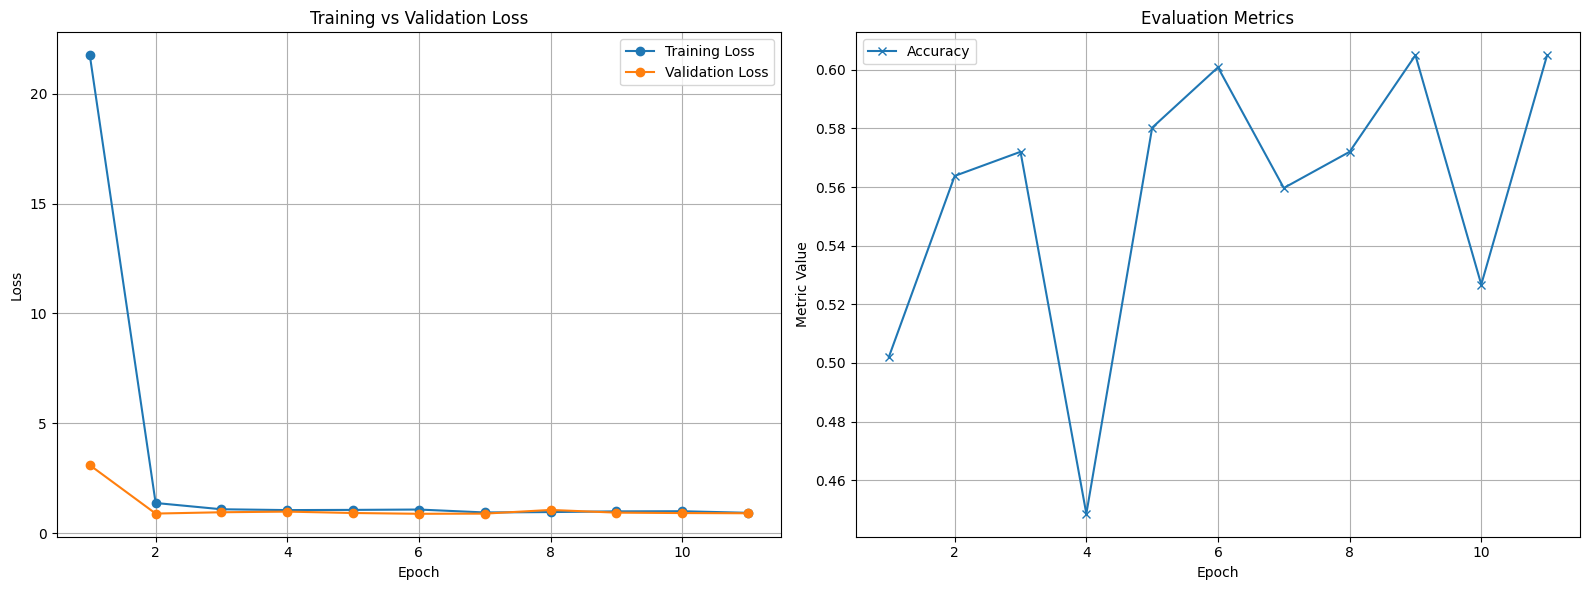

Test dataset: {'eval_loss': 0.9194039106369019, 'eval_accuracy': 0.6008230452674898, 'eval_precision': 0.5773806638151034, 'eval_recall': 0.6008230452674896, 'eval_f1': 0.5432098238424542, 'eval_runtime': 1.1076, 'eval_samples_per_second': 219.388, 'eval_steps_per_second': 27.988, 'epoch': 11.0}
Entrenando el modelo con la configuracion: {'learning_rate': 0.0005, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 15, 'lr_scheduler_type': 'constant', 'warmup_steps': 0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.792700,0.722511,0.646091,0.700345,0.646091,0.593713
2,0.664900,0.630181,0.720165,0.737660,0.720165,0.710552
3,0.621900,0.702424,0.674897,0.720585,0.674897,0.642208
4,0.626800,0.584067,0.748971,0.750632,0.748971,0.749414
5,0.592300,0.602134,0.740741,0.746348,0.740741,0.740448
6,0.562500,0.666156,0.703704,0.741020,0.703704,0.688869
7,0.579900,0.618849,0.707819,0.722024,0.707819,0.701174
8,0.544900,0.626849,0.720165,0.734345,0.720165,0.714140
9,0.550900,0.586313,0.765432,0.768085,0.765432,0.765450


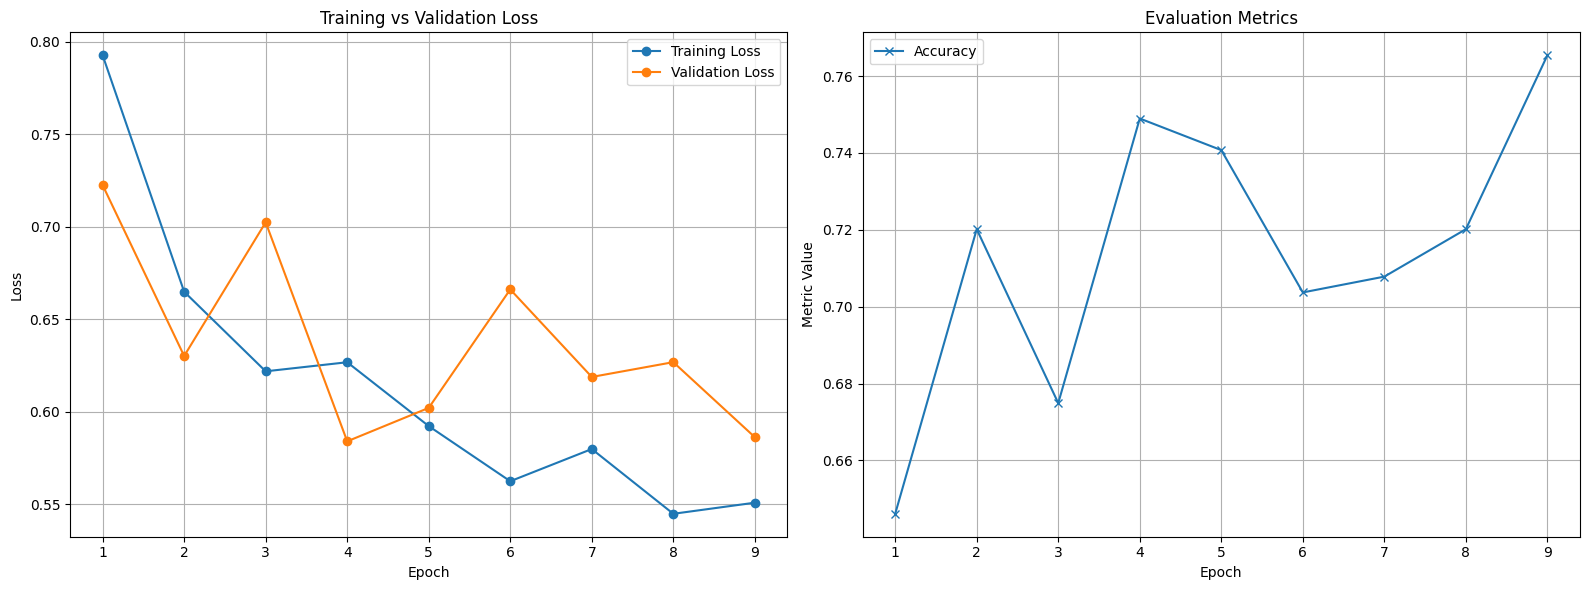

Test dataset: {'eval_loss': 0.5962059497833252, 'eval_accuracy': 0.7530864197530864, 'eval_precision': 0.7572649572649572, 'eval_recall': 0.7530864197530863, 'eval_f1': 0.7539997793225202, 'eval_runtime': 1.1266, 'eval_samples_per_second': 215.687, 'eval_steps_per_second': 27.516, 'epoch': 9.0}
Entrenando el modelo con la configuracion: {'learning_rate': 5e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 30, 'lr_scheduler_type': 'constant', 'warmup_steps': 0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2462878270.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.092900,1.072852,0.522634,0.546674,0.522634,0.518092
2,1.064200,1.042223,0.592593,0.547260,0.592593,0.541601
3,1.038100,1.015273,0.592593,0.539532,0.592593,0.528891
4,1.014200,0.989179,0.584362,0.497682,0.584362,0.491154
5,0.988600,0.965390,0.621399,0.618112,0.621399,0.567960
6,0.966700,0.942821,0.621399,0.609206,0.621399,0.575371
7,0.947700,0.922136,0.637860,0.645528,0.637860,0.594498
8,0.932400,0.903627,0.650206,0.662763,0.650206,0.613433
9,0.914400,0.886543,0.654321,0.672291,0.654321,0.616907
10,0.898800,0.871508,0.654321,0.672291,0.654321,0.616907


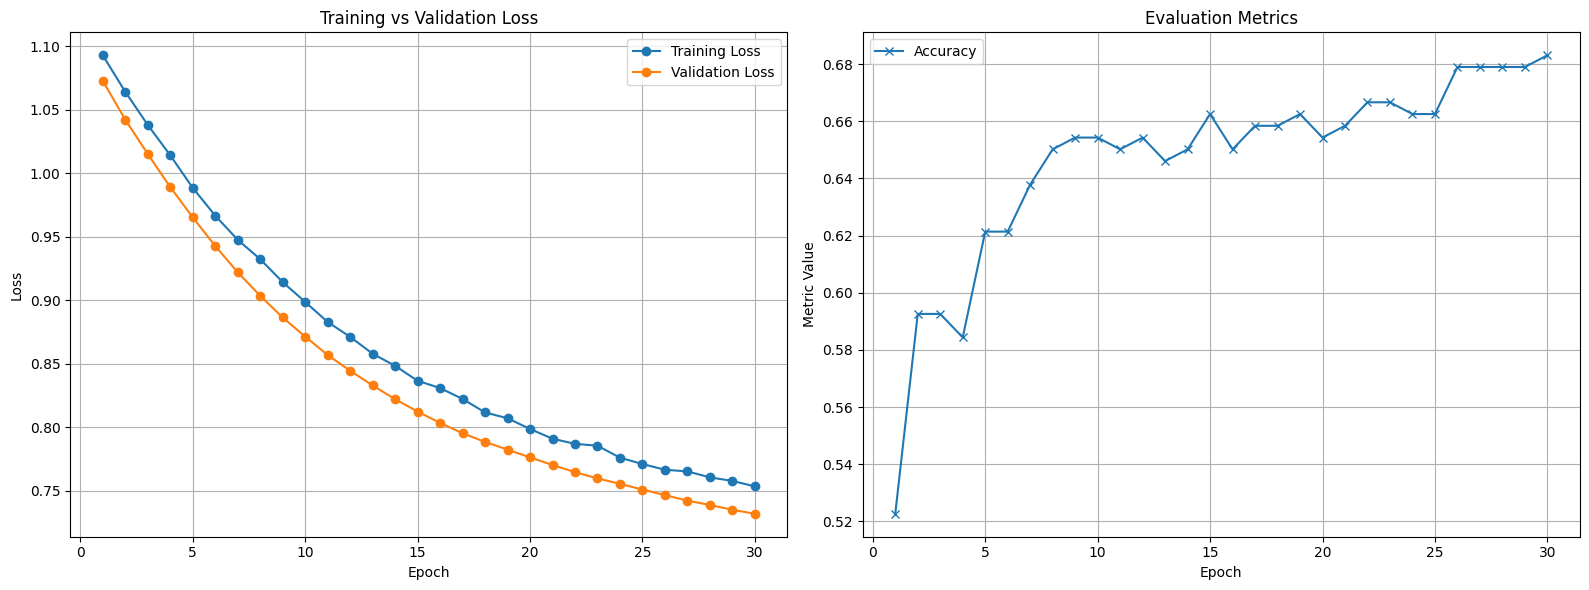

Test dataset: {'eval_loss': 0.7659419775009155, 'eval_accuracy': 0.6419753086419753, 'eval_precision': 0.6267179769103902, 'eval_recall': 0.6419753086419753, 'eval_f1': 0.6220083428491529, 'eval_runtime': 1.1096, 'eval_samples_per_second': 218.989, 'eval_steps_per_second': 27.937, 'epoch': 30.0}
El modelo con menor eval_loss fue el de configuración: {'learning_rate': 0.0005, 'per_device_train_batch_size': 16, 'weight_decay': 0.01, 'num_train_epochs': 15}


In [ ]:
# hyperparameter configurations (with linear scheduler for default)
hyperparameter_configs_linear = [
    {"learning_rate": 5e-2, "per_device_train_batch_size": 16, "weight_decay": 0.01, "num_train_epochs": 15},
    {"learning_rate": 5e-4, "per_device_train_batch_size": 16, "weight_decay": 0.01, "num_train_epochs": 15},
    {"learning_rate": 5e-6, "per_device_train_batch_size": 16, "weight_decay": 0.01, "num_train_epochs": 30},
]

# hyperparameter configurations (with constant scheduler)
hyperparameter_configs_constant = [
    {**config, "lr_scheduler_type": "constant", "warmup_steps": 0}
    for config in hyperparameter_configs_linear
]
# Put together all configurations
hyperparameter_configs = hyperparameter_configs_linear + hyperparameter_configs_constant

bestModel = {}
best_model_info = {}

for i, config in enumerate(hyperparameter_configs):
    print(f"Entrenando el modelo con la configuracion: {config}")
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=3, id2label=id2cath, label2id=cath2id) # the neural network per se, converts tokens to embeddings

    # freeze all parameters, except for the ones in the classification layer
    # distil bert has 6 layers, appart from pre-classifier and classifier layers (the two last ones that we'll train)
    for name, param in model.base_model.named_parameters():
        param.requires_grad = False

    # fine tune
    training_args = TrainingArguments(
        output_dir="./results",          # Directory for saving results
        eval_strategy="epoch",           # evaluate the model at the end of every epoch
        save_strategy="epoch",           # Save a checkpoint every at the end of every epoch
        logging_strategy="epoch",        # log at the end of every epoch
        logging_dir="./logs",            # Directory for logs
        report_to="none",                # Send the train results to wandb
        load_best_model_at_end=True,     # After training, load the model that achieved the best metric_for_best_model
        fp16 = True,                     # Enable mixed precision training
        metric_for_best_model="eval_loss",
        **config
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )

    train_results = trainer.train() # begins training loop
    epoch_logs = [log for log in trainer.state.log_history if "epoch" in log]
    metrics_data = getMetricsDataSimilar(epoch_logs)
    plot_metrics_summary(metrics_data, allMetrics=False)

    less_evalloss = None
    for i in epoch_logs:
        if "eval_loss" in i.keys():
          if not less_evalloss or i["eval_loss"] < less_evalloss:
              less_evalloss = i["eval_loss"]

    if not best_model_info or less_evalloss < best_model_info["eval_loss"]:
        best_model_info["model"] = model
        best_model_info["eval_loss"] = less_evalloss
        best_model_info["config"] = config

c = best_model_info["config"]
print(f"El modelo con menor eval_loss fue el de configuración: {c}")
model = best_model_info["model"]
torch.save(model.state_dict(), '/content/drive/MyDrive/model_overlapped.pth')

# **Testeo de la primer instancia**

In [ ]:
from datasets import load_from_disk
test_dataset = load_from_disk('/content/drive/MyDrive/parecidos_test_dataset')
# print(test_dataset)

In [ ]:
model_path = "distilbert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,  # base model used in fine-tuning
    num_labels=3                # number of output classes
)

# Loads the fine-tuned weights from your Google Drive
model.load_state_dict(torch.load('/content/drive/MyDrive/model_overlapped.pth')) # use this with gpu
# model.load_state_dict(torch.load('/content/drive/MyDrive/model_overlapped.pth', map_location=torch.device('cpu')))

tokenizer = AutoTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
id2cath = {0:"AI",1:"DS",2:"FL"}
cath2id = {"AI":0,"DS":1,"FL":2}

# Checks that we are in evaluation mode
model.eval()

print("Resultados sobre el conjunto de test:")
print(dataset_prediction(model, test_dataset))

# First, 3 classic examples
# Example 1:
example_text1 = "The perceptron training rule converges after a finite number of iterations to a hypothesis that perfectly classifies the training data."
predicted_class1, probs1 = class_prediction(model, example_text1)
print(f"\nTexto 1: '{example_text1}'")
print("  Clase real: AI")
print(f"  Clase Predicha: {predicted_class1}")
print(f"  Probabilidades: {probs1}")

# Example 2:
example_text2 = "A master recurrence describes the running time of a divide-and-conquer algorithm that divides a problem of size n into a subproblems"
predicted_class2, probs2 = class_prediction(model, example_text2)
print(f"\nTexto 2: '{example_text2}'")
print("  Clase real: DS")
print(f"  Clase Predicha: {predicted_class2}")
print(f"  Probabilidades: {probs2}")

# Example 3:
example_text3 = "In automata theory, the result of a nondeterministic automaton is defined to be the the union of the results of all possible executions"
predicted_class3, probs3 = class_prediction(model, example_text3)
print(f"\nTexto 3: '{example_text3}'")
print("  Clase real: FL")
print(f"  Clase Predicha: {predicted_class3}")
print(f"  Probabilidades: {probs3}")

# Noisy examples
# Example 4:
example_text4 = "The probabilistic grammar of the input string defines a series of state transitions within our learning model. We trained a recognizer to classify sequences of symbols, optimizing the production rules for an accurate parse of the linguistic data."
predicted_class4, probs4 = class_prediction(model, example_text4)
print(f"\nTexto 4: '{example_text4}'")
print("  Clase real: AI - FL")
print(f"  Clase Predicha: {predicted_class4}")
print(f"  Probabilidades: {probs4}")

# Example 5:
example_text5 = "The systematic approach that is used in software engineering is sometimes called a software process. A software process is a sequence of activities that leads to the production of a software product."
predicted_class5, probs5 = class_prediction(model, example_text5)
print(f"\nTexto 5: '{example_text5}'")
print("  Clase real: Ninguna")
print(f"  Clase Predicha: {predicted_class5}")
print(f"  Probabilidades: {probs5}")

# Short and Long examples
# Example 6:
example_text6 = "We begin our study with the lambda calculus"
predicted_class6, probs6 = class_prediction(model, example_text6)
print(f"\nTexto 6: '{example_text6}'")
print("  Clase real: FL")
print(f"  Clase Predicha: {predicted_class6}")
print(f"  Probabilidades: {probs6}")

# Example 7:
example_text7 = "Now we turn to functional programming languages (sometimes called applicative languages), where computation is based on the evaluation of expressions and the application of functions rather than on assignment and state change. We begin our study with the lambda calculus, which underlies all functional languages as well as the procedural facilities of many more general languages."
predicted_class7, probs7 = class_prediction(model, example_text7)
print(f"\nTexto 7: '{example_text7}'")
print("  Clase real: FL")
print(f"  Clase Predicha: {predicted_class7}")
print(f"  Probabilidades: {probs7}")

# Example 8:
example_text8 = "A nondeterministic program is one that does not completely determine the behavior of a computer, so that different executions of the same program with the same initial state and input can give different results. Although concurrent programs are usually nondeterministic, the topics of nondeterminism and concurrency are distinct, and it is pedagogically sensible to consider nondeterminism by itself before plunging on to concurrency. Moreover, even with purely sequential computation, nondeterministic programs are often desirable because they avoid unnecessary commitments. Such commitments can make programs harder to read and to reason about. Even more seriously, in programs that use abstract types, they can place unnecessary constraints on the choice of data representations."
predicted_class8, probs8 = class_prediction(model, example_text8)
print(f"\nTexto 8: '{example_text8}'")
print("  Clase real: FL")
print(f"  Clase Predicha: {predicted_class8}")
print(f"  Probabilidades: {probs8}")

# Example 9:
example_text9 = "A nondeterministic program is one that does not completely determine the behavior of a computer"
predicted_class9, probs9 = class_prediction(model, example_text9)
print(f"\nTexto 9: '{example_text9}'")
print("  Clase real: FL")
print(f"  Clase Predicha: {predicted_class9}")
print(f"  Probabilidades: {probs9}")

# One that talks about AI from a differente approach
# Example 10:
example_text10 = "The Imitation Game. I PROPOSE to consider the question, 'Can machines think?'. This should begin with definitions of the meaning of the terms 'machine' and 'think'."
predicted_class10, probs10 = class_prediction(model, example_text10)
print(f"\nTexto 10: '{example_text10}'")
print("  Clase real: AI")
print(f"  Clase Predicha: {predicted_class10}")
print(f"  Probabilidades: {probs10}")

Resultados sobre el conjunto de test:
{'accuracy': 0.7407407407407407, 'precision': 0.7377520913403574, 'recall': 0.7407407407407407, 'f1': 0.7368740152517804, 'per_class_metrics': {'AI': {'precision': np.float64(0.7228915662650602), 'recall': np.float64(0.7407407407407407), 'f1': np.float64(0.7317073170731707)}, 'DS': {'precision': np.float64(0.7802197802197802), 'recall': np.float64(0.8765432098765432), 'f1': np.float64(0.8255813953488372)}, 'FL': {'precision': np.float64(0.7101449275362319), 'recall': np.float64(0.6049382716049383), 'f1': np.float64(0.6533333333333333)}}}

Texto 1: 'The perceptron training rule converges after a finite number of iterations to a hypothesis that perfectly classifies the training data.'
  Clase real: AI
  Clase Predicha: DS
  Probabilidades: [0.039014559239149094, 0.7912652492523193, 0.16972023248672485]

Texto 2: 'A master recurrence describes the running time of a divide-and-conquer algorithm that divides a problem of size n into a subproblems'
  Cla

# **Segunda instancia del modelo**

Creamos la instancia para clases generales. Para este problema, veremos las diferencias al entrenar con datasets de mayor y menor tamaño.

Cargamos el dataset y preparamos el modelo.
El conjunto de evaluación y test se mantienen igual, sólo cambia el tamaño del conjunto de entrenamiento

In [ ]:
# prepare model
id2cath = {0:"Computer Science",1:"Mathematics",2:"Physics"}
cath2id = {"Computer Science":0,"Mathematics":1,"Physics":2}

# load the dataset only once
df = pd.read_csv("/content/dataset_distintos.csv")
df['labels'] = df['labels'].apply(lambda x: cath2id[x]) # replace cathegory names with numbers

all_splits, test_dataset, eval_dataset = create_training_splits(df, [1.0, 0.5, 0.25])

test_dataset.save_to_disk('/content/drive/MyDrive/general_test_dataset')

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Test size: 226
Eval size: 226
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 226
})
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 226
})
1.0
0.0


Map:   0%|          | 0/1052 [00:00<?, ? examples/s]

Train size: 1052
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1052
})
0.5
0.5


Map:   0%|          | 0/526 [00:00<?, ? examples/s]

Train size: 526
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 526
})
0.25
0.75


Map:   0%|          | 0/263 [00:00<?, ? examples/s]

Train size: 263
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 263
})


Saving the dataset (0/1 shards):   0%|          | 0/226 [00:00<?, ? examples/s]

Entrenamos los modelos


Entrenando el modelo con el 100% del dataset


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-681183783.py:492: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Per Class Metrics
1,0.929000,0.783979,0.650442,0.789285,0.568561,0.526554,"{'Computer Science': {'precision': 0.5733333333333334, 'recall': 0.8958333333333334, 'f1': 0.6991869918699187}, 'Mathematics': {'precision': 0.7945205479452054, 'recall': 0.7532467532467533, 'f1': 0.7733333333333333}, 'Physics': {'precision': 1.0, 'recall': 0.05660377358490566, 'f1': 0.10714285714285714}}"
2,0.712600,0.643966,0.774336,0.811055,0.749556,0.763077,"{'Computer Science': {'precision': 0.7428571428571429, 'recall': 0.8125, 'f1': 0.7761194029850746}, 'Mathematics': {'precision': 0.7528089887640449, 'recall': 0.8701298701298701, 'f1': 0.8072289156626506}, 'Physics': {'precision': 0.9375, 'recall': 0.5660377358490566, 'f1': 0.7058823529411765}}"
3,0.614600,0.580692,0.774336,0.784772,0.756540,0.766071,"{'Computer Science': {'precision': 0.7596153846153846, 'recall': 0.8229166666666666, 'f1': 0.79}, 'Mathematics': {'precision': 0.7654320987654321, 'recall': 0.8051948051948052, 'f1': 0.7848101265822784}, 'Physics': {'precision': 0.8292682926829268, 'recall': 0.6415094339622641, 'f1': 0.723404255319149}}"
4,0.561500,0.541979,0.778761,0.792009,0.760869,0.770884,"{'Computer Science': {'precision': 0.7669902912621359, 'recall': 0.8229166666666666, 'f1': 0.7939698492462312}, 'Mathematics': {'precision': 0.7590361445783133, 'recall': 0.8181818181818182, 'f1': 0.7875}, 'Physics': {'precision': 0.85, 'recall': 0.6415094339622641, 'f1': 0.7311827956989247}}"
5,0.538700,0.517789,0.796460,0.805709,0.781496,0.790718,"{'Computer Science': {'precision': 0.7735849056603774, 'recall': 0.8541666666666666, 'f1': 0.8118811881188119}, 'Mathematics': {'precision': 0.8026315789473685, 'recall': 0.7922077922077922, 'f1': 0.7973856209150327}, 'Physics': {'precision': 0.8409090909090909, 'recall': 0.6981132075471698, 'f1': 0.7628865979381443}}"
6,0.517600,0.505424,0.805310,0.816140,0.790401,0.800131,"{'Computer Science': {'precision': 0.7706422018348624, 'recall': 0.875, 'f1': 0.8195121951219512}, 'Mathematics': {'precision': 0.8333333333333334, 'recall': 0.7792207792207793, 'f1': 0.8053691275167785}, 'Physics': {'precision': 0.8444444444444444, 'recall': 0.7169811320754716, 'f1': 0.7755102040816326}}"
7,0.499900,0.500666,0.800885,0.816397,0.780437,0.792720,"{'Computer Science': {'precision': 0.7610619469026548, 'recall': 0.8958333333333334, 'f1': 0.8229665071770335}, 'Mathematics': {'precision': 0.8309859154929577, 'recall': 0.7662337662337663, 'f1': 0.7972972972972973}, 'Physics': {'precision': 0.8571428571428571, 'recall': 0.6792452830188679, 'f1': 0.7578947368421053}}"
8,0.490300,0.486437,0.809735,0.810042,0.795586,0.801543,"{'Computer Science': {'precision': 0.8058252427184466, 'recall': 0.8645833333333334, 'f1': 0.8341708542713567}, 'Mathematics': {'precision': 0.8157894736842105, 'recall': 0.8051948051948052, 'f1': 0.8104575163398693}, 'Physics': {'precision': 0.8085106382978723, 'recall': 0.7169811320754716, 'f1': 0.76}}"
9,0.483700,0.481457,0.809735,0.807845,0.804038,0.805826,"{'Computer Science': {'precision': 0.8247422680412371, 'recall': 0.8333333333333334, 'f1': 0.8290155440414507}, 'Mathematics': {'precision': 0.7948717948717948, 'recall': 0.8051948051948052, 'f1': 0.8}, 'Physics': {'precision': 0.803921568627451, 'recall': 0.7735849056603774, 'f1': 0.7884615384615384}}"
10,0.478500,0.478235,0.809735,0.810042,0.795586,0.801543,"{'Computer Science': {'precision': 0.8058252427184466, 'recall': 0.8645833333333334, 'f1': 0.8341708542713567}, 'Mathematics': {'precision': 0.8157894736842105, 'recall': 0.8051948051948052, 'f1': 0.8104575163398693}, 'Physics': {'precision': 0.8085106382978723, 'recall': 0.7169811320754716, 'f1': 0.76}}"


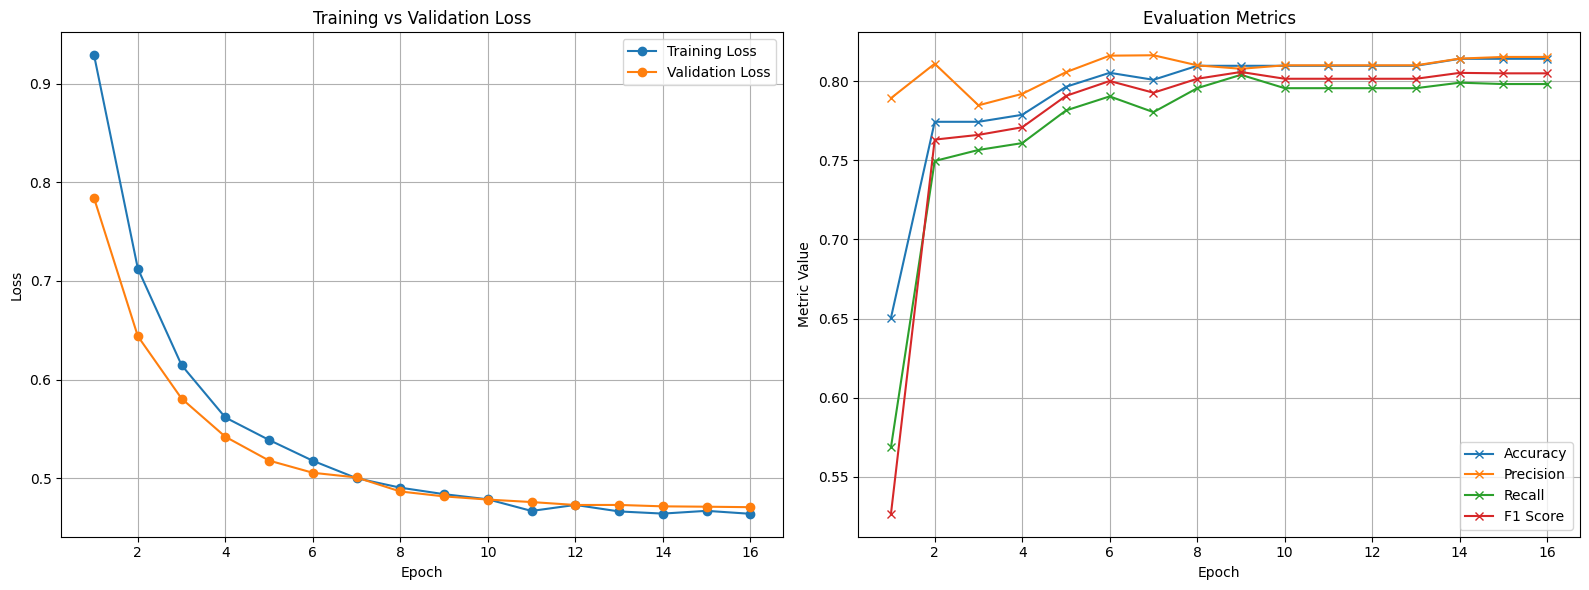

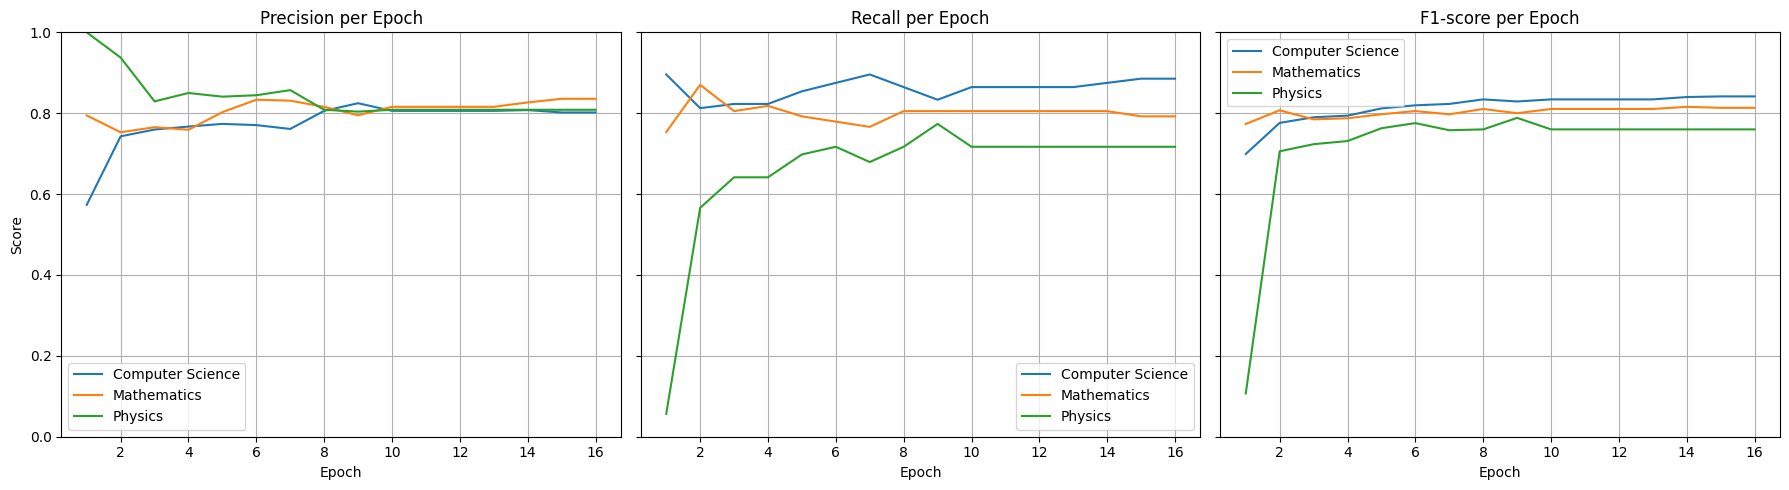


Entrenando el modelo con el 50% del dataset


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-681183783.py:492: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Per Class Metrics
1,1.007800,0.910718,0.632743,0.439535,0.548791,0.484217,"{'Computer Science': {'precision': 0.5655172413793104, 'recall': 0.8541666666666666, 'f1': 0.6804979253112033}, 'Mathematics': {'precision': 0.7530864197530864, 'recall': 0.7922077922077922, 'f1': 0.7721518987341772}, 'Physics': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
2,0.863500,0.794400,0.632743,0.437782,0.548791,0.483543,"{'Computer Science': {'precision': 0.5694444444444444, 'recall': 0.8541666666666666, 'f1': 0.6833333333333333}, 'Mathematics': {'precision': 0.7439024390243902, 'recall': 0.7922077922077922, 'f1': 0.7672955974842768}, 'Physics': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
3,0.765100,0.721184,0.668142,0.751029,0.601923,0.586388,"{'Computer Science': {'precision': 0.6, 'recall': 0.84375, 'f1': 0.7012987012987013}, 'Mathematics': {'precision': 0.7530864197530864, 'recall': 0.7922077922077922, 'f1': 0.7721518987341772}, 'Physics': {'precision': 0.9, 'recall': 0.16981132075471697, 'f1': 0.2857142857142857}}"
4,0.695900,0.670556,0.694690,0.756084,0.639659,0.641313,"{'Computer Science': {'precision': 0.6328125, 'recall': 0.84375, 'f1': 0.7232142857142857}, 'Mathematics': {'precision': 0.7530864197530864, 'recall': 0.7922077922077922, 'f1': 0.7721518987341772}, 'Physics': {'precision': 0.8823529411764706, 'recall': 0.2830188679245283, 'f1': 0.42857142857142855}}"
5,0.655000,0.632138,0.743363,0.793803,0.704064,0.718888,"{'Computer Science': {'precision': 0.6833333333333333, 'recall': 0.8541666666666666, 'f1': 0.7592592592592593}, 'Mathematics': {'precision': 0.775, 'recall': 0.8051948051948052, 'f1': 0.7898089171974523}, 'Physics': {'precision': 0.9230769230769231, 'recall': 0.4528301886792453, 'f1': 0.6075949367088608}}"
6,0.616500,0.604502,0.774336,0.813647,0.746129,0.762680,"{'Computer Science': {'precision': 0.7256637168141593, 'recall': 0.8541666666666666, 'f1': 0.784688995215311}, 'Mathematics': {'precision': 0.7777777777777778, 'recall': 0.8181818181818182, 'f1': 0.7974683544303798}, 'Physics': {'precision': 0.9375, 'recall': 0.5660377358490566, 'f1': 0.7058823529411765}}"
7,0.592800,0.585409,0.769912,0.811496,0.743760,0.761759,"{'Computer Science': {'precision': 0.7130434782608696, 'recall': 0.8541666666666666, 'f1': 0.7772511848341233}, 'Mathematics': {'precision': 0.782051282051282, 'recall': 0.7922077922077922, 'f1': 0.7870967741935484}, 'Physics': {'precision': 0.9393939393939394, 'recall': 0.5849056603773585, 'f1': 0.7209302325581395}}"
8,0.577800,0.570609,0.769912,0.805601,0.745720,0.762946,"{'Computer Science': {'precision': 0.7130434782608696, 'recall': 0.8541666666666666, 'f1': 0.7772511848341233}, 'Mathematics': {'precision': 0.7894736842105263, 'recall': 0.7792207792207793, 'f1': 0.7843137254901961}, 'Physics': {'precision': 0.9142857142857143, 'recall': 0.6037735849056604, 'f1': 0.7272727272727273}}"
9,0.555600,0.556978,0.769912,0.805673,0.746577,0.763636,"{'Computer Science': {'precision': 0.7105263157894737, 'recall': 0.84375, 'f1': 0.7714285714285715}, 'Mathematics': {'precision': 0.7922077922077922, 'recall': 0.7922077922077922, 'f1': 0.7922077922077922}, 'Physics': {'precision': 0.9142857142857143, 'recall': 0.6037735849056604, 'f1': 0.7272727272727273}}"
10,0.547100,0.549135,0.774336,0.803606,0.750049,0.765813,"{'Computer Science': {'precision': 0.7192982456140351, 'recall': 0.8541666666666666, 'f1': 0.780952380952381}, 'Mathematics': {'precision': 0.8026315789473685, 'recall': 0.7922077922077922, 'f1': 0.7973856209150327}, 'Physics': {'precision': 0.8888888888888888, 'recall': 0.6037735849056604, 'f1': 0.7191011235955056}}"


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

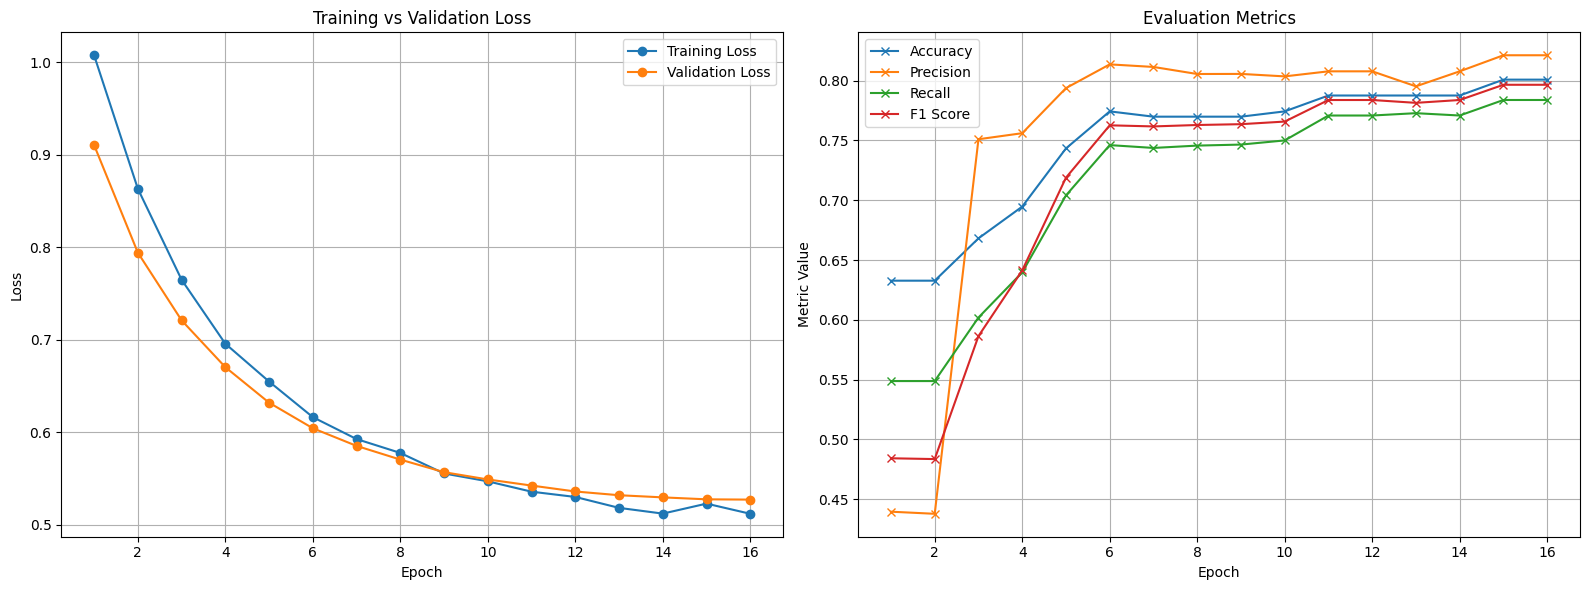

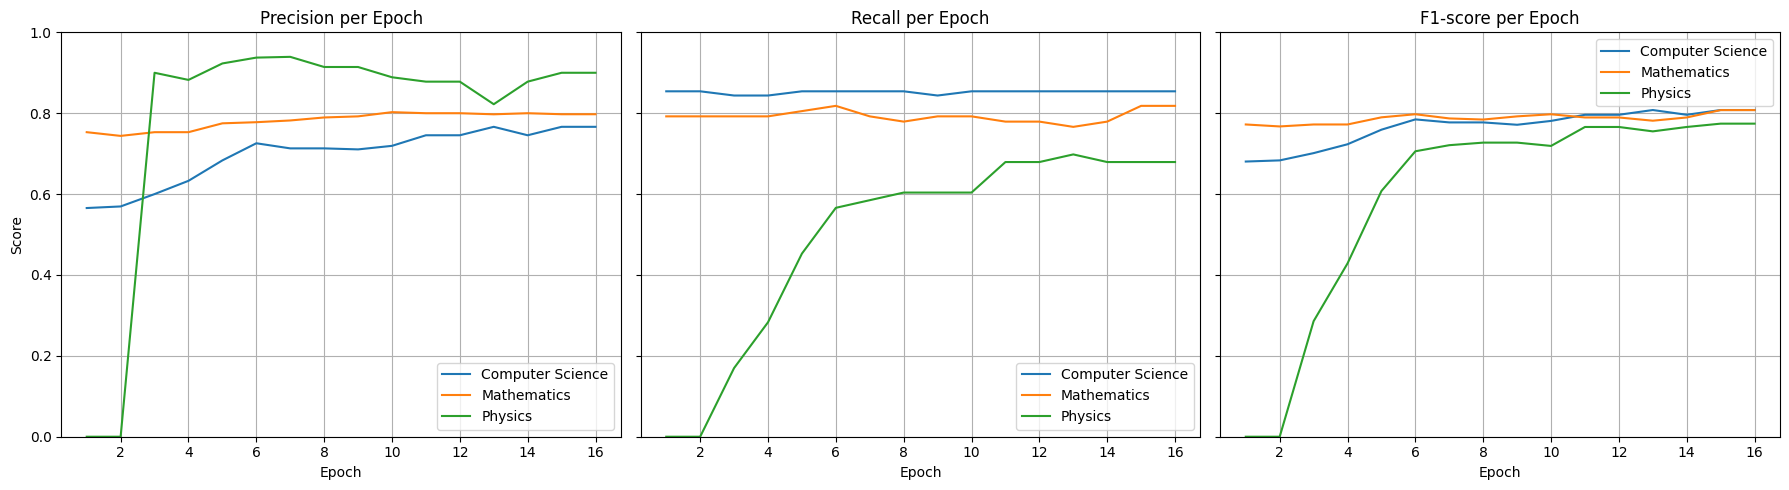


Entrenando el modelo con el 25% del dataset


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-681183783.py:492: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Per Class Metrics
1,1.057500,0.990165,0.628319,0.469612,0.537608,0.482049,"{'Computer Science': {'precision': 0.5421686746987951, 'recall': 0.9375, 'f1': 0.6870229007633588}, 'Mathematics': {'precision': 0.8666666666666667, 'recall': 0.6753246753246753, 'f1': 0.7591240875912408}, 'Physics': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
2,0.944000,0.913123,0.637168,0.466316,0.547123,0.489085,"{'Computer Science': {'precision': 0.5527950310559007, 'recall': 0.9270833333333334, 'f1': 0.6926070038910506}, 'Mathematics': {'precision': 0.8461538461538461, 'recall': 0.7142857142857143, 'f1': 0.7746478873239436}, 'Physics': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
3,0.881900,0.855484,0.637168,0.457247,0.549693,0.489681,"{'Computer Science': {'precision': 0.5548387096774193, 'recall': 0.8958333333333334, 'f1': 0.6852589641434262}, 'Mathematics': {'precision': 0.8169014084507042, 'recall': 0.7532467532467533, 'f1': 0.7837837837837838}, 'Physics': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}"
4,0.805400,0.801842,0.637168,0.769250,0.555081,0.495595,"{'Computer Science': {'precision': 0.5815602836879432, 'recall': 0.8541666666666666, 'f1': 0.6919831223628692}, 'Mathematics': {'precision': 0.7261904761904762, 'recall': 0.7922077922077922, 'f1': 0.7577639751552795}, 'Physics': {'precision': 1.0, 'recall': 0.018867924528301886, 'f1': 0.037037037037037035}}"
5,0.760400,0.758575,0.663717,0.780345,0.590856,0.560158,"{'Computer Science': {'precision': 0.6029411764705882, 'recall': 0.8541666666666666, 'f1': 0.7068965517241379}, 'Mathematics': {'precision': 0.7380952380952381, 'recall': 0.8051948051948052, 'f1': 0.7701863354037267}, 'Physics': {'precision': 1.0, 'recall': 0.11320754716981132, 'f1': 0.2033898305084746}}"
6,0.723700,0.728289,0.659292,0.743377,0.591305,0.572558,"{'Computer Science': {'precision': 0.5912408759124088, 'recall': 0.84375, 'f1': 0.6952789699570815}, 'Mathematics': {'precision': 0.75, 'recall': 0.7792207792207793, 'f1': 0.7643312101910829}, 'Physics': {'precision': 0.8888888888888888, 'recall': 0.1509433962264151, 'f1': 0.25806451612903225}}"
7,0.688600,0.702500,0.685841,0.764381,0.625120,0.618484,"{'Computer Science': {'precision': 0.6230769230769231, 'recall': 0.84375, 'f1': 0.7168141592920354}, 'Mathematics': {'precision': 0.7469879518072289, 'recall': 0.8051948051948052, 'f1': 0.775}, 'Physics': {'precision': 0.9230769230769231, 'recall': 0.22641509433962265, 'f1': 0.36363636363636365}}"
8,0.666200,0.682031,0.712389,0.767758,0.660896,0.664852,"{'Computer Science': {'precision': 0.6585365853658537, 'recall': 0.84375, 'f1': 0.7397260273972602}, 'Mathematics': {'precision': 0.75, 'recall': 0.8181818181818182, 'f1': 0.782608695652174}, 'Physics': {'precision': 0.8947368421052632, 'recall': 0.32075471698113206, 'f1': 0.4722222222222222}}"
9,0.631800,0.667004,0.725664,0.780803,0.681724,0.693520,"{'Computer Science': {'precision': 0.6639344262295082, 'recall': 0.84375, 'f1': 0.7431192660550459}, 'Mathematics': {'precision': 0.7654320987654321, 'recall': 0.8051948051948052, 'f1': 0.7848101265822784}, 'Physics': {'precision': 0.9130434782608695, 'recall': 0.39622641509433965, 'f1': 0.5526315789473685}}"
10,0.619100,0.655025,0.738938,0.790895,0.697775,0.711771,"{'Computer Science': {'precision': 0.6776859504132231, 'recall': 0.8541666666666666, 'f1': 0.7557603686635944}, 'Mathematics': {'precision': 0.775, 'recall': 0.8051948051948052, 'f1': 0.7898089171974523}, 'Physics': {'precision': 0.92, 'recall': 0.4339622641509434, 'f1': 0.5897435897435898}}"


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

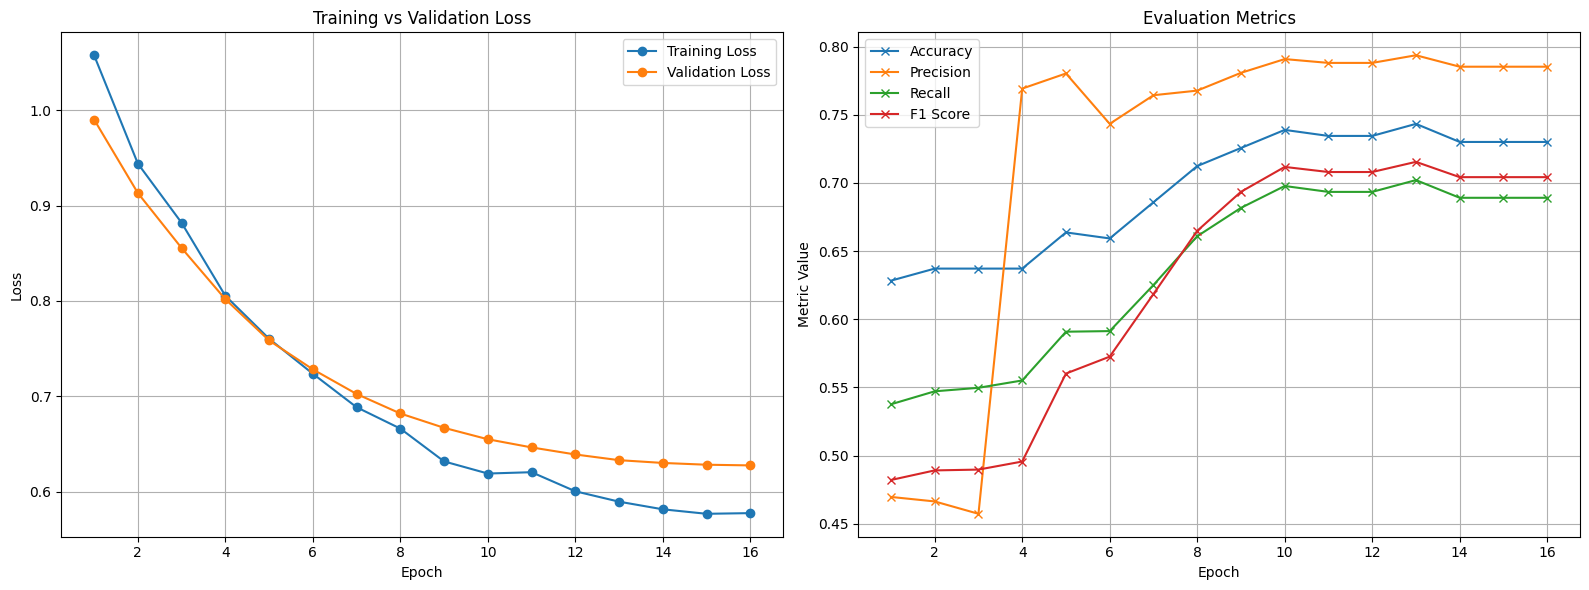

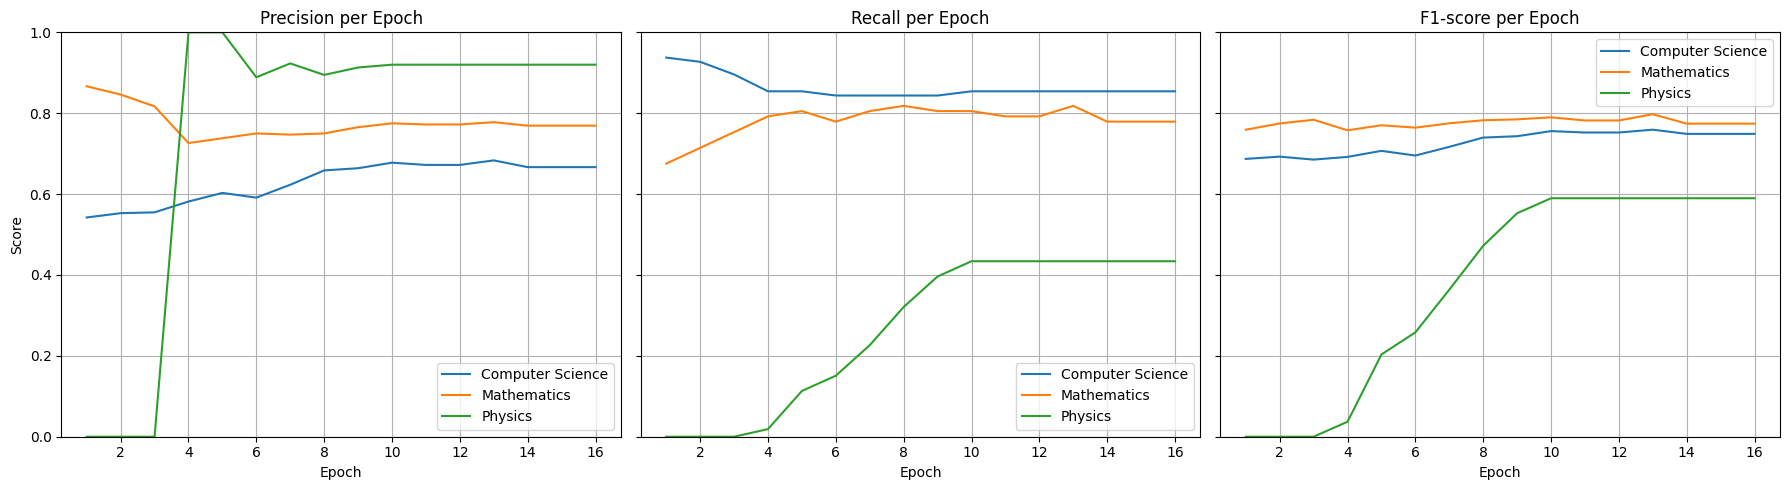


El modelo con menor eval_loss fue el entrenado con un 100% del dataset


In [ ]:
compute_metrics = Metrics(id2cath)

model = train_and_select_best_model(all_splits, test_dataset,
                            eval_dataset, tokenizer, compute_metrics,
                            model_path, id2cath, cath2id)
torch.save(model.state_dict(), '/content/drive/MyDrive/model_general.pth')

# **Testeo de la segunda instancia**

Cargamos el modelo si ya fue entrenado, y el conjunto de test

In [ ]:
from datasets import load_from_disk
test_dataset = load_from_disk('/content/drive/MyDrive/general_test_dataset')
print(test_dataset)

Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 226
})


In [ ]:
model_path = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# Load the fine-tuned weights from Google Drive
model.load_state_dict(torch.load('/content/drive/MyDrive/model_general.pth'))

tokenizer = AutoTokenizer.from_pretrained(model_path)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Testeamos

In [ ]:
id2cath = {0:"Computer Science",1:"Mathematics",2:"Physics"}
cath2id = {"Computer Science":0,"Mathematics":1,"Physics":2}

# Checks that we are in evaluation mode
model.eval()

# Metrics for test set
print("Resultados sobre el conjunto de test:")
print(dataset_prediction(model, test_dataset))

# Example 1: Computer Science
example_text = "KuaiLive: A Real-time Interactive Dataset for Live Streaming Recommendation Live streaming platforms have become a dominant form of online content consumption"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 1: '{example_text}'")
print("  Clase real: CS")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 2: Computer Science, (Example 2 extended)
example_text = "KuaiLive: A Real-time Interactive Dataset for Live Streaming Recommendation Live streaming platforms have become a dominant form of online content consumption, offering dynamically evolving content, real-time interactions, and highly engaging user experiences. These unique characteristics introduce"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 2: '{example_text}'")
print("  Clase real: CS")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 3: Computer Science, (Example 2 desorganized)
example_text = "Real-time Interactive A for Live Streaming A Recommendation streaming platforms have become Live a dominant of online content consumption form, dynamically evolving content, real-time offering  interactions, and highly user experiences. engaging unique These characteristics introduce KuaiLive: "
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 3: '{example_text}'")
print("  Clase real: CS")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 4: Ninguna
example_text = "$a(t, x) \( u_t -$"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 4: '{example_text}'")
print("  Clase real: NING")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 5: Mathematics
example_text = "Coefficient Identification Problem with Integral Overdetermination Condition for Diffusion Equations In this paper, we investigate a nonlinear inverse problem aimed at recovering a coefficient $a(t, x)$, dependent on both time and a subset of spatial variables, in a diffusion equation \( u_t -"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 5: '{example_text}'")
print("  Clase real: MATH")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 6: Mathemataics
example_text = "On the optimization of the Robin eigenvalues in some classes of polygons Given the eigenvalue problem for the Laplacian with Robin boundary conditions, (with $\beta\in\R\setminus\{0\}$ the Robin parameter), we consider a shape minimization problem for a function of the first eigenvalues"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 6: '{example_text}'")
print("  Clase real: MATH")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 7: Physics
example_text = "Status and prospects of Muon g-2 experiment This article reviews the muon g-2 experiment, a cornerstone in precision tests of the Standard Model of particle physics."
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 7: '{example_text}'")
print("  Clase real: PHY")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 8: Physics (Example 7 extended)
example_text = "Status and prospects of Muon g-2 experiment This article reviews the muon g-2 experiment, a cornerstone in precision tests of the Standard Model of particle physics. The experiment measures the anomalous magnetic moment of the muon with unprecedented accuracy, seeking potential discrepancies"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 8: '{example_text}'")
print("  Clase real: PHY")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 9: Physics
example_text = "On operation and control of CW magnetrons"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 9: '{example_text}'")
print("  Clase real: PHY")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 10: Physics (Example 9 extended)
example_text = "On operation and control of CW magnetrons for superconducting accelerators CW magnetrons, developed for industrial RF heaters, were suggested to feed RF cavities of superconducting accelerators due to higher efficiency and lower cost of RF power than provide traditionally used klystrons, IOTs or"
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 10: '{example_text}'")
print("  Clase real: PHY")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 11: Physics
example_text = "IOTs or On operation accelerators CW magnetrons, developed for industrial higher efficiency  RF heaters, were suggested to feed RF cavities of superconducting accelerators and control of CW magnetrons for superconducting due to and lower cost of RF power than provide traditionally used klystrons, "
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 11: '{example_text}'")
print("  Clase real: PHY")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")

# Example 12: Ninguna
example_text = ""
predicted_class, probs = class_prediction(model, example_text)
print(f"\nTexto 12: '{example_text}'")
print("  Clase real: Ning")
print(f"  Clase Predicha: {predicted_class}")
print(f"  Probabilidades: {probs}")


Resultados sobre el conjunto de test:
{'accuracy': 0.8097345132743363, 'precision': 0.8130272382484773, 'recall': 0.8097345132743363, 'f1': 0.8090890770125289, 'per_class_metrics': {'Computer Science': {'precision': np.float64(0.780952380952381), 'recall': np.float64(0.8541666666666666), 'f1': np.float64(0.8159203980099502)}, 'Mathematics': {'precision': np.float64(0.8181818181818182), 'recall': np.float64(0.8181818181818182), 'f1': np.float64(0.8181818181818182)}, 'Physics': {'precision': np.float64(0.8636363636363636), 'recall': np.float64(0.7169811320754716), 'f1': np.float64(0.7835051546391752)}}}

Texto 1: 'KuaiLive: A Real-time Interactive Dataset for Live Streaming Recommendation Live streaming platforms have become a dominant form of online content consumption'
  Clase real: CS
  Clase Predicha: Computer Science
  Probabilidades: [0.9190044403076172, 0.022200068458914757, 0.0587955117225647]

Texto 2: 'KuaiLive: A Real-time Interactive Dataset for Live Streaming Recommendation 